## E.P.S.M. Project
- Lazy Evaluation of Goal Specifications Guided by Motion Planning <br/>Juan David Hern'andez, Mark Moll, and Lydia E. Kavraki
- Students: Petre Ovidiu Adrian (343C3) & Stanciu Stefan Lucian (343C5)
<br/>
### Clarifications
This project focuses on the implementation of the planning algorithm described in the paper and thus it completly disregards other aspects of the scenarios such as the semantic entity used to interpret ambiguous human requests.

### Planning algorithm implementation

In [2]:
from treelib import Node, Tree
from random import randint, choice
from heapq import heappop, heappush, heapify

EPS = 50

def isValid(x, y):
    """Checks if a point is inside Cfree or not"""
    if (c_space[x][y] == OBS):
        return False
    return True


def goalRegionSampler(GR):
    """Create a list of goal samples for each goal region"""
    heap = []
    heapify(heap)

    for i, gr in enumerate(GR):
        seg = choice(gr)
        top_left = seg[0]
        bottom_right = seg[1]
        while True:
            x = randint(top_left[0], bottom_right[0])
            y = randint(top_left[1], bottom_right[1])
            if (isValid(x, y)):
                break
        heappush(heap, (-1.0, (x, y)))
    return heapq


def genRandomConf(node):
    pass


# DEV: GR - lista de tupluri (1/goal region) cu perechi de coordonate ex: [(((100,100),(200,200)), ((250,280),(300,300)))]
def plan(qs, GR, bias=True):
    reached_gr = False
    goal_biased = False
    tree = Tree()
    tree.create_node('qs', qs)

    g_heap = goalRegionSampler(GR)
    while not reached_gr:
        if (bias):
            q_towards = g_heap[0]
            goal_biased = True
        else:
            # DEV: choose random node and expand in random direction for max EPS units
            q_towards = genRandomConf()
            goal_biased = False
        break


### Input data
The following plot represents a bidimentional space C (Cfree U Cobs) on which the algorith will be applied.

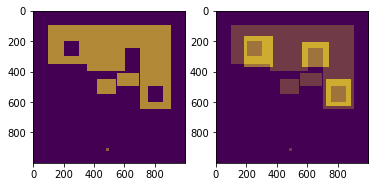

In [3]:
import matplotlib.pyplot as plt
import numpy as np

OBS = 1
GOAL = 2
NODE = 3

def fill(matrix, start, end, val):
    """Create zones by providing top left and bottom right coordinates in a matrix"""
    for i in range(start[0], end[0]):
        for j in range(start[1], end[1]):
            matrix[i][j] = val
    return matrix

c_space = np.zeros((1000, 1000))
gr = np.zeros((1000, 1000))
nodes = np.zeros((1000, 1000))

# DEV: te rog lasa o linie libera intre figuri care nu se ating
# Create Cobs
c_space = fill(c_space, (100, 100), (200, 900), OBS)
c_space = fill(c_space, (200, 100), (350, 200), OBS)
c_space = fill(c_space, (300, 200), (350, 300), OBS)
c_space = fill(c_space, (200, 300), (350, 350), OBS)
c_space = fill(c_space, (200, 350), (400, 600), OBS)
c_space = fill(c_space, (200, 600), (250, 700), OBS)

c_space = fill(c_space, (410, 550), (500, 690), OBS)

c_space = fill(c_space, (450, 420), (550, 540), OBS)

c_space = fill(c_space, (200, 700), (500, 900), OBS)
c_space = fill(c_space, (500, 700), (600, 750), OBS)
c_space = fill(c_space, (500, 850), (600, 900), OBS)
c_space = fill(c_space, (600, 700), (650, 900), OBS)

# DEV: te rog lasa o linie libera intre figuri care nu se ating
# Create Goal Regions
# GR1
gr = fill(gr, (170, 180), (370, 370), GOAL)
# GR2
gr = fill(gr, (210, 560), (370, 740), GOAL)
# GR3
gr = fill(gr, (450, 720), (630, 880), GOAL)

# Create qs - start node
nodes = fill(nodes, (900, 480), (920, 500), NODE)

# Display matrix
plt.figure()
plt.subplot(1,2,1)
plt.imshow(nodes, interpolation='none')
plt.imshow(c_space, interpolation='none', alpha=0.6)
plt.subplot(1,2,2)
plt.imshow(nodes, interpolation='none')
plt.imshow(c_space, interpolation='none', alpha=0.5)
plt.imshow(gr, interpolation='none', alpha=0.5)
plt.show()